In [7]:

import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt



In [10]:
# ======================
# 3️⃣ PREPROCESSING
# ======================
X = train_df.drop("accident_risk", axis=1)
y = train_df["accident_risk"].values

cat_cols = X.select_dtypes(include=["object", "bool"]).columns
num_cols = X.select_dtypes(include=["float64", "int64"]).columns

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

X_processed = preprocessor.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

In [11]:
# ======================
# 4️⃣ MOVE EVERYTHING TO GPU
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32, device=device)
y_val = torch.tensor(y_val, dtype=torch.float32, device=device).view(-1, 1)


🔥 Using device: cuda


In [33]:
class AccidentRiskModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)


In [34]:
# ======================
# 6️⃣ TRAIN LOOP (GPU SHUFFLE)
# ======================
num_epochs = 100
batch_size = 1024
train_rmse, val_rmse = [], []

for epoch in range(num_epochs):
    model.train()

    # ---- GPU SHUFFLE ----
    perm = torch.randperm(X_train.size(0), device=device)
    X_train = X_train[perm]
    y_train = y_train[perm]

    total_loss = 0.0
    for i in range(0, X_train.size(0), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)

    train_loss = np.sqrt(total_loss / X_train.size(0))

    # ---- VALIDATION ----
    model.eval()
    with torch.no_grad():
        preds = model(X_val)
        val_loss = criterion(preds, y_val).item()
        val_rmse_epoch = np.sqrt(val_loss)

    train_rmse.append(train_loss)
    val_rmse.append(val_rmse_epoch)

    print(f"Epoch {epoch+1}/{num_epochs} | Train RMSE: {train_loss:.4f} | Val RMSE: {val_rmse_epoch:.4f}")


Epoch 1/100 | Train RMSE: 0.0575 | Val RMSE: 0.0573
Epoch 2/100 | Train RMSE: 0.0576 | Val RMSE: 0.0571
Epoch 3/100 | Train RMSE: 0.0575 | Val RMSE: 0.0572
Epoch 4/100 | Train RMSE: 0.0575 | Val RMSE: 0.0572
Epoch 5/100 | Train RMSE: 0.0575 | Val RMSE: 0.0572
Epoch 6/100 | Train RMSE: 0.0575 | Val RMSE: 0.0572
Epoch 7/100 | Train RMSE: 0.0575 | Val RMSE: 0.0571
Epoch 8/100 | Train RMSE: 0.0575 | Val RMSE: 0.0573
Epoch 9/100 | Train RMSE: 0.0575 | Val RMSE: 0.0572
Epoch 10/100 | Train RMSE: 0.0576 | Val RMSE: 0.0571
Epoch 11/100 | Train RMSE: 0.0575 | Val RMSE: 0.0573
Epoch 12/100 | Train RMSE: 0.0575 | Val RMSE: 0.0571
Epoch 13/100 | Train RMSE: 0.0575 | Val RMSE: 0.0571
Epoch 14/100 | Train RMSE: 0.0575 | Val RMSE: 0.0571
Epoch 15/100 | Train RMSE: 0.0575 | Val RMSE: 0.0571
Epoch 16/100 | Train RMSE: 0.0575 | Val RMSE: 0.0571
Epoch 17/100 | Train RMSE: 0.0575 | Val RMSE: 0.0572
Epoch 18/100 | Train RMSE: 0.0575 | Val RMSE: 0.0573
Epoch 19/100 | Train RMSE: 0.0575 | Val RMSE: 0.0573
Ep

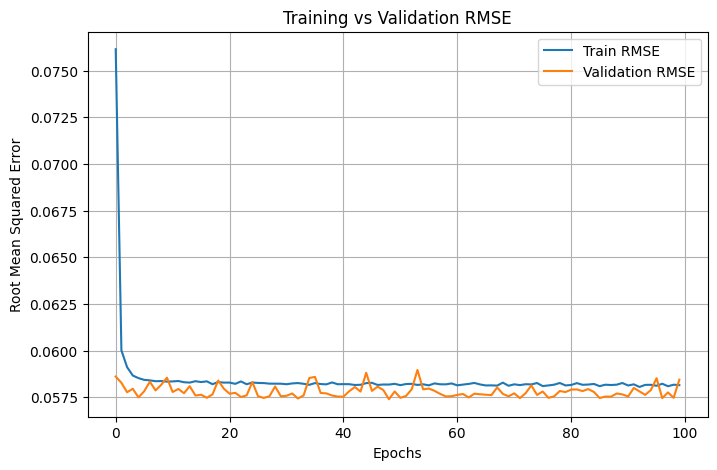

✅ Model saved successfully!


In [24]:
# ======================
# 7️⃣ PLOT RMSE
# ======================
plt.figure(figsize=(8,5))
plt.plot(train_rmse, label="Train RMSE")
plt.plot(val_rmse, label="Validation RMSE")
plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")
plt.title("Training vs Validation RMSE")
plt.legend()
plt.grid(True)
plt.show()

# ======================
# 8️⃣ SAVE MODEL
# ======================
torch.save(model.state_dict(), "accident_risk_model_gpu.pth")
print("✅ Model saved successfully!")

In [30]:
# ======================
# 9️⃣ TEST PREDICTIONS
# ======================
test_df = pd.read_csv("/home/ahmad/kaggle/Accident prediction/test.csv")

test_df["speed_limit_curvature"] = test_df["speed_limit"] * test_df["curvature"]
test_df["speed_limit_num_lanes"] = test_df["speed_limit"] * test_df["num_lanes"]
test_df["curvature_num_lanes"] = test_df["curvature"] * test_df["num_lanes"]
test_df["lighting_weather"] = test_df["lighting"].astype(str) + "_" + test_df["weather"].astype(str)
test_df["lighting_numeric"] = test_df["lighting"].astype("category").cat.codes
test_df["lighting_curvature"] = test_df["lighting_numeric"] * test_df["curvature"]

# --- 🧩 ADD YOUR NEW FEATURE HERE AS WELL (same as train) ---
test_df["school_season"] = test_df["school_season"].astype(int)
test_df["holiday"] = test_df["holiday"].astype(int)
time_of_day_dummies = pd.get_dummies(test_df["time_of_day"], prefix="time_of_day")
for col in time_of_day_dummies.columns:
    test_df[f"{col}_x_schoolseason_x_holiday"] = (
        test_df["school_season"] * test_df["holiday"] * time_of_day_dummies[col]
    )

# --- Transform and predict ---
X_test = preprocessor.transform(test_df)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)

model.eval()
with torch.no_grad():
    preds = model(X_test).cpu().numpy().flatten()

submission = pd.DataFrame({
    "id": test_df["id"],
    "predicted_risk": preds
})

# --- 💾 Choose output path ---
output_path = "/home/ahmad/kaggle/Accident prediction/submission3.csv"
submission.to_csv(output_path, index=False)
print(f"✅ Predictions saved to {output_path}")

✅ Predictions saved to /home/ahmad/kaggle/Accident prediction/submission3.csv
